<a href="https://colab.research.google.com/github/DayakarReddyT/AQI_Deployment/blob/main/sentiment_analysis_with_hotel_reviews_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Sentiment analysis is part of the Natural Language Processing (NLP) techniques that consists in extracting emotions related to some raw texts. This is usually used on social media posts and customer reviews in order to automatically understand if some users are positive or negative and why. The goal of this study is to show how sentiment analysis can be performed using python. Here are some of the main libraries we will use:

- NLTK: the most famous python module for NLP techniques
- Gensim: a topic-modelling and vector space modelling toolkit
- Scikit-learn: the most used python machine learning library

We will use here some hotel reviews data. Each observation consists in one customer review for one hotel. Each customer review is composed of a textual feedback of the customer's experience at the hotel and an overall rating. The data can be found here:
https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

For each textual review, we want to predict if it corresponds to a good review (the customer is happy) or to a bad one (the customer is not satisfied). The reviews overall ratings can range from 2.5/10 to 10/10. In order to simplify the problem we will split those into two categories:
- bad reviews have overall ratings < 5
- good reviews have overall ratings >= 5

The challenge here is to be able to predict this information using only the raw textual data from the review.
Let's get it started!


# Load data

We first start by loading the raw data. Each textual reviews is splitted into a positive part and a negative part. We group them together in order to start with only raw text data and no other information.

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import opendatasets as od
import pandas
  
od.download(
    "https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dayakarreddyt
Your Kaggle Key: ··········


100%|██████████| 45.1M/45.1M [00:01<00:00, 25.0MB/s]


In [3]:
file =('515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv')

In [4]:
import pandas as pd
reviews_df = pd.read_csv(file)

In [4]:
import pandas as pd

file =('515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv')
# read data
reviews_df = pd.read_csv(file)
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


# Sample data

In [5]:
reviews_df.shape

(515738, 2)

In [6]:
#reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)
reviews_df = reviews_df.sort_values(  by="is_bad_review")
reviews_df['is_bad_review'].value_counts()

0    493457
1     22281
Name: is_bad_review, dtype: int64

In [7]:
reviews_df = reviews_df.iloc[460000:]
reviews_df['is_bad_review'].value_counts()

0    33457
1    22281
Name: is_bad_review, dtype: int64

Reviews data is sampled in order to speed up computations.

# Clean data

In [8]:
# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

If the user doesn't leave any negative feedback comment, this will appear as "No Negative" in our data. This is the same for the positive comments with the default value "No Positive". We have to remove those parts from our texts.

The next step consists in cleaning the text data with various operations:

In [9]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


To clean textual data, we call our custom 'clean_text' function that performs several transformations:
- lower the text
- tokenize the text (split the text into words) and remove the punctuation
- remove useless words that contain numbers
- remove useless stop words like 'the', 'a' ,'this' etc.
- Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
- lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

Now that we have cleaned our data, we can do some feature engineering for our modelization part.

# Feature engineering

In [10]:
# add sentiment anaylsis columns
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:
- a neutrality score
- a positivity score
- a negativity score
- an overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [11]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

Next, we add some simple metrics for every text:
- number of characters in the text
- number of words in the text

In [12]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [13]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document. 

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:
- TF computes the classic number of times the word appears in the text
- IDF computes the relative importance of this word which depends on how many texts the word can be found

We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [14]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yet,word_yo,word_yoghurt,word_yogurt,word_young,word_youth,word_yummy,word_zero,word_zip,word_zone
138909,Iron didn t work and I didn t like that we ha...,0,iron work like stayed long staff friendly abdu...,0.000,0.697,0.303,0.9364,215,43,0.118790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138908,Over 200 per night is double what i d expect ...,0,per night double expect pay city quality londo...,0.036,0.777,0.186,0.7779,181,36,-0.071649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138907,There wasn t anything we didn t like about th...,0,anything like hotel hotel great position camde...,0.000,0.763,0.237,0.9081,241,50,0.074760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138920,Parking nightmare breakfast ingredients could...,0,park nightmare breakfast ingredient could bett...,0.000,0.767,0.233,0.8225,177,29,-0.218909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138875,Modern decor Good location for Royal Albert H...,0,modern decor good location royal albert hall m...,0.000,0.756,0.244,0.4404,61,11,-0.064968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
reviews_df.shape

(55738, 4439)

# Exploratory data analysis


In order to have a better understanding of our data, let's explore it a little:

In [16]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.600255
1    0.399745
Name: is_bad_review, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:

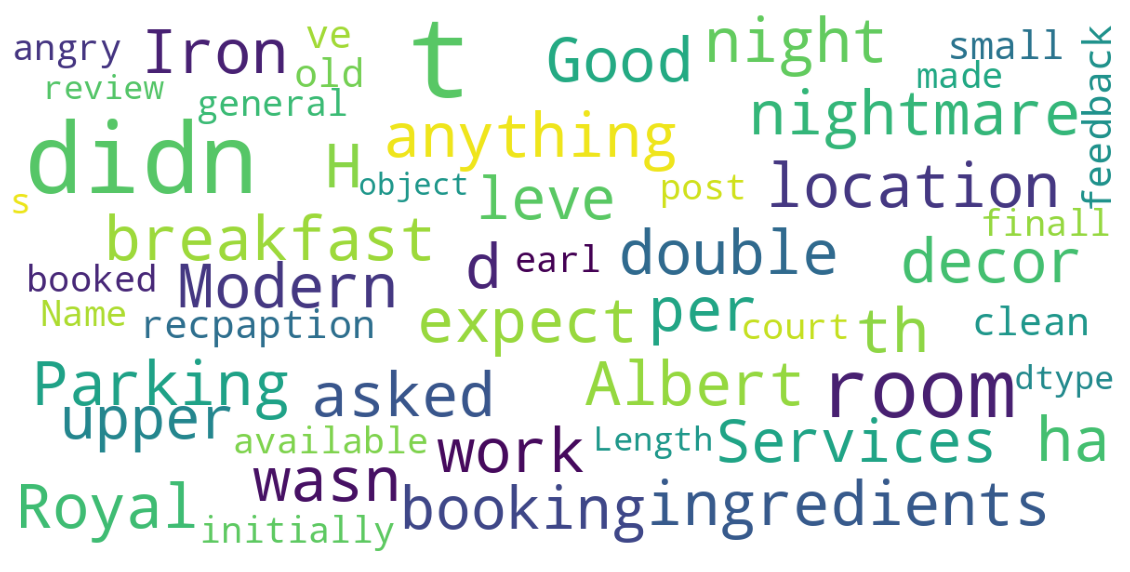

In [17]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

Most of the words are indeed related to the hotels: room, staff, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

In [18]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
180510,A super friendly welcome,1.000
173978,clean comfortable attractive,1.000
176633,Clean helpful efficient,1.000
182878,Best location comfortable clean,0.911
173854,Excellent location clean comfortable,0.907
175551,Friendly welcome Comfortable room,0.905
167878,Very comfortable Good value,0.904
342506,Smile More friendly I hope,0.902
145743,Good value amazing location,0.901
168611,Friendly staff good value,0.895


The most positive reviews indeed correspond to some good feedbacks.

In [19]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
166515,No complaints No complaints,1.000
177895,No A C,1.000
476092,All No no no,0.868
67391,Abusive sarcastic m staff,0.861
102885,Dirty very dirty,0.859
318516,A disaster Nothing,0.804
494849,dirty old bad food noisy,0.802
152744,Noisy unpleasant staff poor room,0.798
271383,Very bad Very bad,0.791
425970,Bad Wifi Bad cleaning,0.778


Some errors can be found among the most negative reviews: Vader sometimes interpret 'no' or 'nothing' as negative words whereas they are sometimes used to say that there were no problems with the hotel. Fortunately, most of the reviews are indeed bad ones.

<ipython-input-20-78be2137db92>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label = label)
<ipython-input-20-78be2137db92>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(subset['compound'], hist = False, label = label)


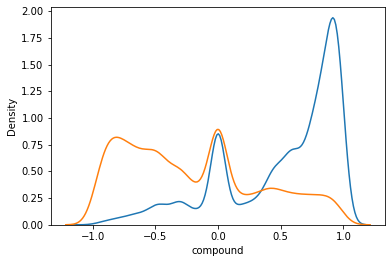

In [20]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, bad reviews tend to have lower compound sentiment scores.

This shows us that previously computed sentiment features will be very important in our modelling part.

# Modelling reviewer_score

In [21]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [22]:
y_train

133039    0
186400    0
167798    0
344398    1
108139    1
         ..
337777    1
398273    1
67223     1
134039    0
171516    0
Name: is_bad_review, Length: 44590, dtype: int64

We first choose which features we want to use to train our model. Then we split our data into two parts:
- one to train our model
- one to assess its performances

We will next use a Random Forest (RF) classifier for our predictions.

In [23]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Algorith Name : Nearest Neighbors Classifier --> Accuracy  :: 72.2551130247578
Precision: 0.669
Recall: 0.614
F1 Score: 0.640


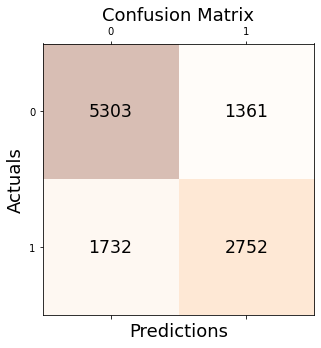

In [35]:
# -------- Nearest Neighbors ----------
from sklearn import neighbors

model4 = neighbors.KNeighborsClassifier()
model4.fit(X_train[:20000], y_train[:20000])

# make predictions for test data
y_pred = model4.predict(X_test)
# calculate the accuracy score
accuracy =  accuracy_score(y_test, y_pred) * 100

print('Algorith Name : '+ str("Nearest Neighbors Classifier") + ' --> Accuracy  :: '+ str(accuracy))

#precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision_score(y_test, y_pred))
# recall: tp / (tp + fn)
#recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, y_pred)
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Algorith Name : Nearest Neighbors Classifier --> Accuracy  :: 72.2551130247578
Precision: 0.669
Recall: 0.614
F1 Score: 0.640


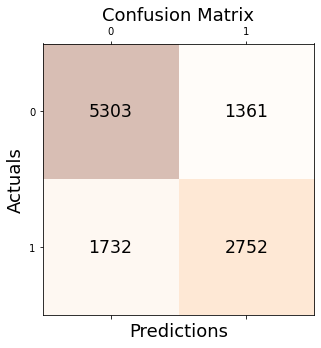

In [36]:
# --------- Gaussian Naive Bayes ---------
from sklearn.naive_bayes import GaussianNB

model5 = GaussianNB()

model5 = neighbors.KNeighborsClassifier()
model5.fit(X_train[:20000], y_train[:20000])

# make predictions for test data
y_pred = model5.predict(X_test)
# calculate the accuracy score
accuracy =  accuracy_score(y_test, y_pred) * 100

print('Algorith Name : '+ str("Nearest Neighbors Classifier") + ' --> Accuracy  :: '+ str(accuracy))

#precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision_score(y_test, y_pred))
# recall: tp / (tp + fn)
#recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, y_pred)
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Algorith Name : Logistic Regression --> Accuracy  :: 83.62935055615357
Precision: 0.800
Recall: 0.790
F1 Score: 0.795


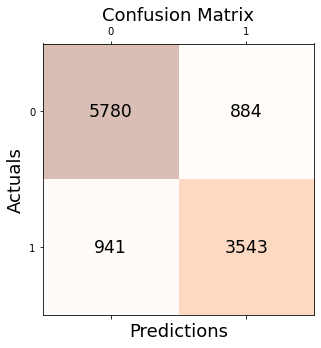

In [34]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train[:20000], y_train[:20000])

# make predictions for test data
y_pred = model1.predict(X_test)
# calculate the accuracy score
accuracy =  accuracy_score(y_test, y_pred) * 100

print('Algorith Name : '+ str('Logistic Regression') + ' --> Accuracy  :: '+ str(accuracy))

#precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision_score(y_test, y_pred))
# recall: tp / (tp + fn)
#recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, y_pred)
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Algorith Name : Decision Tree --> Accuracy  :: 78.19339791890923
Precision: 0.717
Recall: 0.756
F1 Score: 0.736


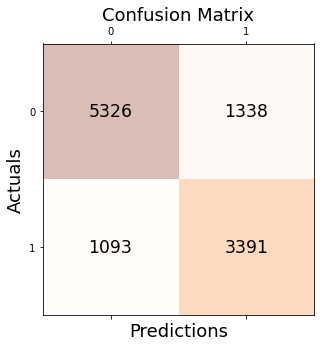

In [25]:
# ---- Decision Tree -----------
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
# calculate the accuracy score
accuracy =  accuracy_score(y_test, y_pred) * 100

print('Algorith Name : '+ str('Decision Tree') + ' --> Accuracy  :: '+ str(accuracy))

#precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision_score(y_test, y_pred))
# recall: tp / (tp + fn)
#recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, y_pred)
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Algorith Name : Decision Tree --> Accuracy  :: 83.95227843559383
Precision: 0.806
Recall: 0.791
F1 Score: 0.799


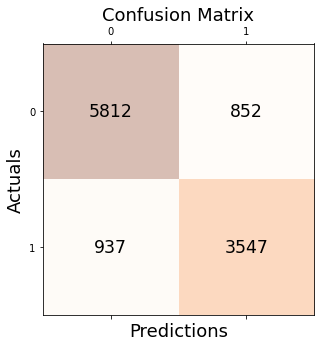

In [27]:
# ---- Decision Tree -----------
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
model2.fit(X_train, y_train)

# make predictions for test data
y_pred = model2.predict(X_test)
# calculate the accuracy score
accuracy =  accuracy_score(y_test, y_pred) * 100

print('Algorith Name : '+ str('Decision Tree') + ' --> Accuracy  :: '+ str(accuracy))

#precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision_score(y_test, y_pred))
# recall: tp / (tp + fn)
#recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, y_pred)
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Algorith Name : XGBoost Tree --> Accuracy  :: 84.32902762827413
Precision: 0.813
Recall: 0.793
F1 Score: 0.803


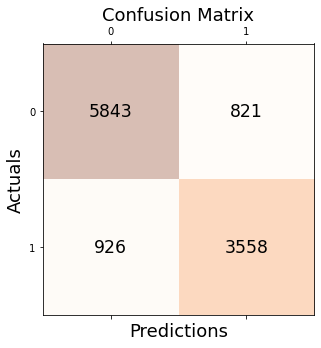

In [28]:
# ---- Decision Tree -----------
from xgboost import XGBClassifier

model3 = XGBClassifier()
model3.fit(X_train, y_train)

# make predictions for test data
y_pred = model3.predict(X_test)
# calculate the accuracy score
accuracy =  accuracy_score(y_test, y_pred) * 100

print('Algorith Name : '+ str('XGBoost Tree') + ' --> Accuracy  :: '+ str(accuracy))

#precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision_score(y_test, y_pred))
# recall: tp / (tp + fn)
#recall = recall_score(y_test, y_pred)
print('Recall: %.3f' % recall_score(y_test, y_pred))
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, y_pred)
print('F1 Score: %.3f' % f1_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.075372
2,pos,0.060854
0,neg,0.046316
8,doc2vec_vector_2,0.031488
1,neu,0.023594
10,doc2vec_vector_4,0.022361
4,nb_chars,0.017969
6,doc2vec_vector_0,0.017038
5,nb_words,0.016244
7,doc2vec_vector_1,0.015533


The most important features are indeed the ones that come from the previous sentiment analysis. The vector representations of the texts also have a lot of importance in our training. Some words appear to have a fairly good importance as well.

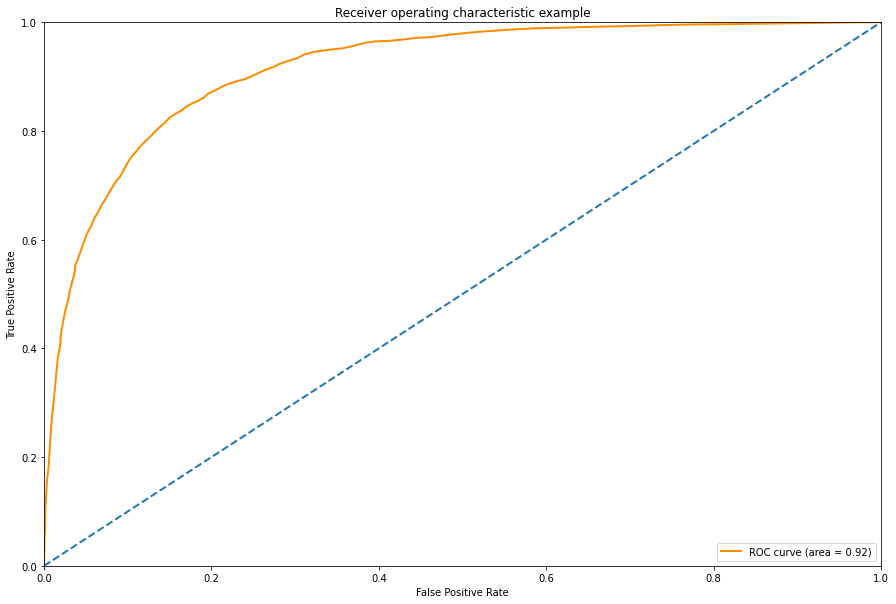

In [30]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of our classifier. The higher the curve is above the diagonal baseline, the better the predictions. Although the AUC ROC (Area Under the Curve ROC) is very good, we should not use here the ROC curve to assess the quality of our model.

Why? First let us remind the False Positive Rate formula, which corresponds to the x axis of the ROC curve: FPR (False Positive Rate) = # False Positives / # Negatives.

Here the # Negatives corresponds to our number of good reviews which is very high because our dataset is imbalanced. This means that even with some False Positives, our FPR will tend to stay very low. Our model will be able to make a lot of false positives predictions and still have a low false positive rate, while increasing the true positive rate and therefore artificially increasing the AUC ROC metric.

In [32]:
pip install funcsigs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.87')

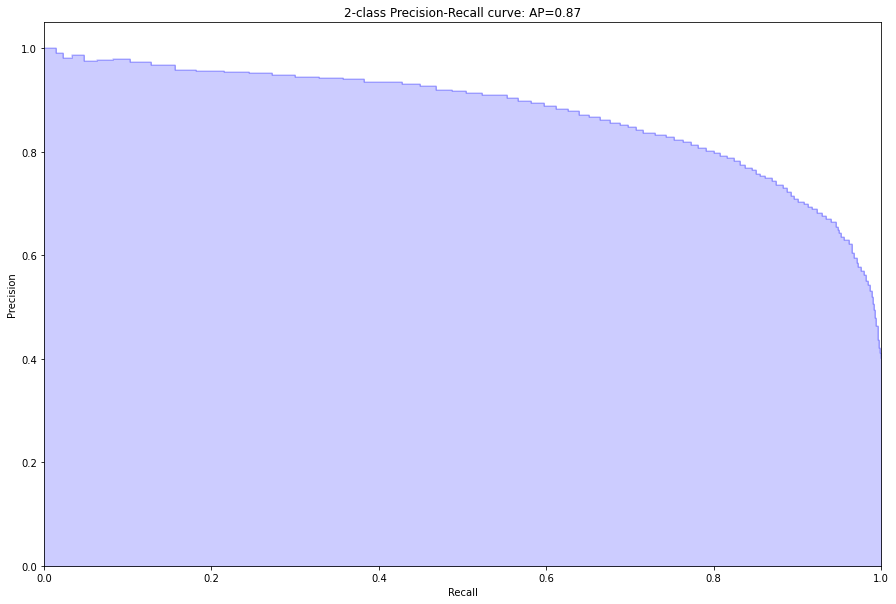

In [33]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

A better metric in this imbalanced situation is the AUC PR (Area Under the Curve Precision Recall), or also called AP (Average Precision). 

We can see that the precision decreases when we increase the recall. This shows us that we have to choose a prediction thresold adapted to our needs. If our goal is to have a high recall, we should set a low prediction thresold that will allow us to detect most of the observations of the positive class, but with a low precision. On the contrary, if we want to be really confident about our predictions but don't mind about not finding all the positive observations, we should set a high thresold that will get us a high precision and a low recall.

In order to know if our model performs better than another classifier, we can simply use the AP metric. To assess the quality of our model, we can compare it to a simple decision baseline. Let's take a random classifier as a baseline here that would predict half of the time 1 and half of the time 0 for the label.

Such a classifier would have a precision of 4.3%, which corresponds to the proportion of positive observations. For every recall value the precision would stay the same, and this would lead us to an AP of 0.043. The AP of our model is approximately 0.35, which is more than 8 times higher than the AP of the random method. This means that our model has a good predictive power.

# Conclusion

It is completely possible to use only raw text as input for making predictions. The most important thing is to be able to extract the relevant features from this raw source of data. This kind of data can often come as a good complementary source in data science projects in order to extract more learning features and increase the predictive power of the models.